# Image inversion with numpy

## Read training data

In [1]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import tables

In [2]:
# Convert PIL image to 200x200 array normalised to -0.5 to 0.5 rage.
def image_2_array(filename):
    # PIL image pil_img
    pil_img=Image.open(filename)
    pil_arr=np.array(pil_img)
    pil_max = np.amax(np.absolute(pil_arr))
    pil_min = np.amin(np.absolute(pil_arr))
    #print ("Max/min:"+ str(pil_max)+"/"+str(pil_min))
    if pil_max == 0:
        return pil_img,pil_arr
    pil_scaled_arr = (pil_arr / pil_max) - 0.5
    return pil_img, pil_scaled_arr

# Invert normalised PIL image
def invert_array(arr):
    #print(arr.shape)
    #print(arr[100][50:60])
    inverted_arr = arr * (-1)
    #print(inverted_arr[100][50:60])
    return inverted_arr
    
# Convert normalized array to PIL image
def array_2_image(arr):
    MAX = 255
    arr_scaled = (arr + 0.5) * MAX
    arr_max = np.amax(arr_scaled)
    arr_min = np.amin(arr_scaled)
    #print ("Array Max/min:"+ str(arr_max)+"/"+str(arr_min))
    im = Image.fromarray(arr_scaled)
    return im

# I. Image inversion

In [3]:
# Prepare inversed images
plot = False
save = False  # Only need to save once
if save:
    for dataset in range(1, 11):
        for img_counter in range(1, 11):
            # Read Image
            dataset_str = str(dataset).zfill(3)
            image_str = str(img_counter).zfill(4)
            filename = "/notebooks/data001/move" + \
                    dataset_str+"_"+image_str+".gif"
            #print filename
            img,a = image_2_array(filename)
            #print("Orgarr:")
            #print(a)


            in_arr = invert_array(a)
            #print("Invarr:")
            #print(in_arr)
            new_im = array_2_image(in_arr)
            new_filename = "/notebooks/data001/move_inv_" + \
                    dataset_str+"_"+image_str+".gif"
            # Save new image to file
            new_im.save(new_filename, "GIF")
            # Plot
            if (plot):
                _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
                ax1.imshow(img);
                ax2.imshow(a, vmin=-0.5, vmax=0.5,cmap=plt.cm.Greys);
                ax3.imshow(in_arr, cmap=plt.cm.Greys);
                ax4.imshow(new_im);



# Prepare training set

train_data_onedimension получается из:

1 картинка 200x200 px = 40 000<br>
8 наборов (range) по 10 картинок (img_counter) = 80<br>
Итого: 40 000 * 80 = 3 200 000

In [4]:
# Read training images into array of shape (80, 200, 200, 1)
IMSIZE=200
train_data_onedimension = np.array([]) #np.empty([80,200,200,1])
train_labl_onedimension = np.array([])
for dataset in range(1, 9):
    for img_counter in range(1, 11):
        dataset_str = str(dataset).zfill(3)
        image_str = str(img_counter).zfill(4)
        # Samples
        filename = "data001/move" + \
                dataset_str+"_"+image_str+".gif"
        #print filename
        img, a = image_2_array(filename)
        
        train_data_onedimension = np.append(train_data_onedimension, a)
        # Targets (labels)
        filename = "data001/move_inv_" + \
                dataset_str+"_"+image_str+".gif"
        #print filename
        img,a = image_2_array(filename)
        train_labl_onedimension = np.append(train_labl_onedimension, a)
        
        
print train_data_onedimension.shape
print train_labl_onedimension.shape

images_in_set = train_data_onedimension.size / (IMSIZE*IMSIZE)
print images_in_set
train_data = train_data_onedimension.reshape(images_in_set, IMSIZE, IMSIZE, 1)
print train_data.shape
train_labl = train_labl_onedimension.reshape(images_in_set, IMSIZE, IMSIZE, 1)
print train_labl.shape

(3200000,)
(3200000,)
80
(80, 200, 200, 1)
(80, 200, 200, 1)


## Newral Network 

L – Number of layers = 3

$s_j$ – кол-во элементов в слое j

Кол-во элементов по слоям:
$s_1$ = 40000
$s_2$ = 40000
$s_3$ = 40000



In [7]:
L = 3
s1= IMSIZE*IMSIZE
s = np.ones(L, dtype=np.int) * s1
s

array([40000, 40000, 40000])

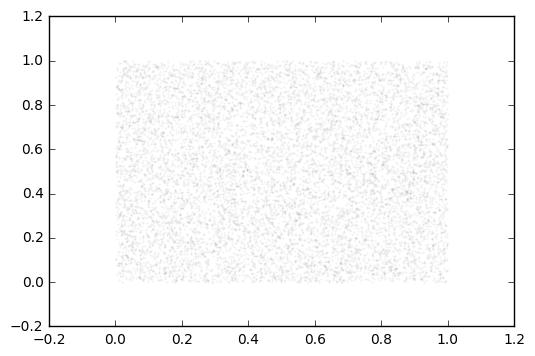

In [8]:
def plot_data(data):
    #plt.figure()
    c = ["#000000"]
    s = 0.1
    plt.scatter(data[:, 0], data[:, 1], s = s, c = c, alpha = 0.1)
    #plt.axis('off')
    #plt.title("Scatter")
    
    
plt.figure()
test_data=np.random.rand(10000,10000)
plot_data(test_data)
plt.show()

In [13]:
import time
hdf_path = 'all_data.hdf'

try:
    f = tables.open_file(hdf_path, mode='r')
    f.close()
except:
    print "Error"
    pass
try:
    f = tables.open_file(hdf_path, 'w')
except:
    print "Closing"
    f.close()
root = f.root
shape=(0, s1)
atom = tables.Float16Atom()
filters = tables.Filters(complevel=5, complib='blosc')
x = f.create_earray(root,'x', atom, filters = filters,
                    shape = shape, expectedrows = s1)
print x.shape
start = time.clock()
step=2000
for i in range(0, s1, step):
    print i
    rnd = np.random.rand(step, s1)
    x.append(rnd)
end = time.clock()
print x
print "Execution time: ", end-start
f.close()

(0, 40000)
0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
/x (EArray(40000, 40000), shuffle, blosc(5)) ''
Execution time:  124.499485


_With filters: запись в файл стала примерно в 1.5 раза медленее  – 90s / 120s, размер файла на диске не изменился – 3GB._

0
(1000, 40000)
10000
(1000, 40000)
20000
(1000, 40000)
30000
(1000, 40000)


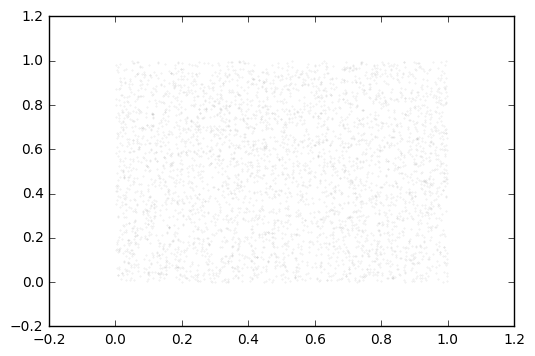

In [14]:
f = tables.open_file(hdf_path, mode='r')
plt.figure()
for i in range(0,s1,10000):
    print i
    x = f.root.x[i:i+1000]
    print x.shape
    plot_data(x)
f.close()
plt.show()

Links:
http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-carray-class
http://www.pytables.org/usersguide/tutorials.html
https://kastnerkyle.github.io/posts/using-pytables-for-larger-than-ram-data-processing/


### Test read data from all_data.hdf

In [ ]:
f = tables.open_file(hdf_path, mode='r')
hdf5_data = read_hdf5_file.root.x[:]

### 1. Random $\Theta$ initialisation

$\epsilon=0.5$

In [11]:
import pandas as pd

In [10]:
INIT_EPSILON=0.5
Theta = []
for j in range(1,L):
    print j, s[j-1], s[j]*(s[j-1]+1)
    theta = np.zeros((s[j],s[j-1]+1), dtype = np.float16)
    theta[:] = np.random.rand(theta.shape) * (2*INIT_EPSILON) - INIT_EPSILON
    Theta.append(theta) 
print Theta.shape

1 40000 1600040000


MemoryError: 

```
1
40000
---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
<ipython-input-12-8f1caaf32a38> in <module>()
      4     print(j)
      5     print(s[j-1])
----> 6     theta = np.random.rand(s[j],s[j-1]+1) * (2*INIT_EPSILON) - INIT_EPSILON
      7     Theta.append(theta)
      8 print Theta.shape

mtrand.pyx in mtrand.RandomState.rand (numpy/random/mtrand/mtrand.c:17649)()

mtrand.pyx in mtrand.RandomState.random_sample (numpy/random/mtrand/mtrand.c:13944)()

mtrand.pyx in mtrand.cont0_array (numpy/random/mtrand/mtrand.c:2204)()

MemoryError: 
```

_Note: Access $\Theta_1$ as `Theta[0]`, $\Theta_2$ as `Theta[1]`._


For regularisation use matrix $\Theta$ without first (bias) column. Name it $\hat{\Theta}$. Store it in list of arrays `Theta_r`.

### 2. Forward propagation

### 3. Cost function

$$J(\Theta) = \frac{1}{2m} \sum_{i=1}^{m}\sum_{k=1}^{K}(h_\Theta(x^i)_k - y^i_k)^2 + \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{o=1}^{s_l}\sum_{p=1}^{s_{l+1}}(\hat{\Theta}_{p,o}^l)^2 $$

$\hat{\Theta}$ - Theta_r - $\Theta$ without first column.

In code below:

$\lambda = lmbd$,

$h_{\Theta} = H$

In [14]:
# Return cost and gradient for given Theta.
# Parameters:
# Theta – weights,
# L – number of layers in NN,
# s – number of elements in each layer,
# H – hypothesis data,
# Y – target data,
# lmbd – regularisation parameter lambda.
def costFunction(Theta, L, s, H, Y, lmbd):
    # Initialisation. Need to return the following variables:
    J = 0;
    Theta_grad = []
    for j in range(1,L):
        Theta_grad.append(np.zeros(size(Theta[j-1])))
                          
    # Remove first column from Theta1
    Theta_r = []
    for j in range(1,L):
        theta_reduced = Theta[j-1][:, 1:]
        Theta_r.append(theta_reduced)
        print(Theta_r[j-1].shape)
        
    # SUM for J



In [11]:
x = np.array([[[1],[2],[3]], [[4],[5],[6]]])
x.shape
x[:,0:2]
x.sum()

21